In [11]:
import random
import numpy as np

DATA = np.genfromtxt('Paridad.csv', delimiter=',')
MAX_profundidad = 5

class Node:
    def __init__(self, valor):
        self.valor = valor
        self.hijos = []

    def agregar_hijo(self, hijo):
        self.hijos.append(hijo)

def and_func(x, y):
    return x and y

def or_func(x, y):
    return x or y

def not_func(x):
    return not x

def nor_func(x, y):
    return not (x or y)

def crear_arbol(profundidad):
    if profundidad <= 0 or random.random() < 0.1:
        return Node(random.choice(['A', 'B', 'C']))
    else:
        node_type = random.choice(['AND', 'OR', 'NOT'])
        node = Node(node_type)
        for _ in range(2 if node_type in ['AND', 'OR'] else 1):
            node.hijos.append(crear_arbol(profundidad - 1))
        return node

def imprimir_arbol(node, indent=0):
    if node is not None:
        print('-' * indent + node.valor)
        for hijo in node.hijos:
            imprimir_arbol(hijo, indent + 2)

def calcular_profundidades(nodo):
    if nodo.hijos == []:
        return 1
    else:
        return 1 + max([calcular_profundidades(hijo) for hijo in nodo.hijos])

def evaluar_arbol(arbol, a, b, c):
    # funcion recursiva que evalua el arbol, solo evalua para 1 renglon de la tabla de verdad
    if arbol.valor == 'A':
        return a
    elif arbol.valor == 'B':
        return b
    elif arbol.valor == 'C':
        return c
    elif arbol.valor == 'AND':
        return and_func(evaluar_arbol(arbol.hijos[0], a, b, c), evaluar_arbol(arbol.hijos[1], a, b, c))
    elif arbol.valor == 'OR':
        return or_func(evaluar_arbol(arbol.hijos[0], a, b, c), evaluar_arbol(arbol.hijos[1], a, b, c))
    elif arbol.valor == 'NOT':
        return not_func(evaluar_arbol(arbol.hijos[0], a, b, c))
    else:
        pass
    
def evaluar_arbol_completo(arbol):
    # funcion que evalua el arbol para todas las combinaciones de la tabla de verdad
    correctas = 0
    incorrectas = 0
    for i in DATA:
        prediccion = evaluar_arbol(arbol, i[0], i[1], i[2])
        # print("Prediccion: ", prediccion)
        # print("Respuesta esperada: ", i[3])
        if prediccion == i[3]:
            correctas += 1
        else:
            incorrectas += 1
    fitness = correctas/(correctas+incorrectas)
    # print("Correctas: ", correctas)
    # print("Incorrectas: ", incorrectas)
    # print("Porcentaje de acierto: ",fitness)
    return fitness

def mutacion(arbol, prob=0.1):
    # funcion que muta un arbol/individuo
    
    if random.random() < prob:
        prob = 0
        return crear_arbol(MAX_profundidad)
    else:
        nuevo_arbol = Node(arbol.valor)
        for hijo in arbol.hijos:
            nuevo_arbol.hijos.append(mutacion(hijo))
        return nuevo_arbol

def cruzamiento(arbol1, arbol2, prob = 0.8):
    if random.random() > prob:
        return arbol2, arbol1
    else:
        nodos_a1 = num_nodos(arbol1)
        nodos_a2 = num_nodos(arbol2)
        subarbol1 = encontrar_subarbol(arbol1)
        subarbol2 = encontrar_subarbol(arbol2)
        hijo1 = insertar_subarbol(arbol1, subarbol2, nodos_a1)
        hijo2 = insertar_subarbol(arbol2, subarbol1, nodos_a2)
        hijo1 = mutacion(hijo1)
        hijo2 = mutacion(hijo2)
        return hijo1, hijo2
    


def obtener_nodos(raiz):
    if not raiz:
        return []
    
    lista_nodos = []
    stack = [raiz]

    while stack:
        node = stack.pop()
        lista_nodos.append(node)
        stack.extend(node.hijos)
    return lista_nodos

def encontrar_subarbol(raiz):
    if not raiz:
        return None
    lista_nodo = obtener_nodos(raiz)
    random_node = random.choice(lista_nodo)
    return crear_arbol_rec(random_node)

def crear_arbol_rec(node):
    if not node:
        return None
    raiz_subarbol = Node(node.valor)
    for hijo in node.hijos:
        subtree_hijo = crear_arbol_rec(hijo)
        raiz_subarbol.agregar_hijo(subtree_hijo)
    return raiz_subarbol

  
def insertar_subarbol(arbol, subarbol, num_nodos):
    prob = 3/num_nodos
    if arbol.hijos == []:
        return subarbol
    else:
        for i, hijo in enumerate(arbol.hijos):
            if random.random() < prob:
                arbol.hijos[i] = subarbol
                return arbol
            else:
                return insertar_subarbol(hijo, subarbol, num_nodos-1)

def num_nodos(arbol):
    if arbol.hijos == []:
        return 1
    else:
        return 1 + sum([num_nodos(hijo) for hijo in arbol.hijos])


In [16]:
def seleccionar_padres_ruleta(fitness):
    # seleccionar padres con probabilidad proporcional al fitness
    suma_fitness = sum(fitness)
    probabilidad = [fit/suma_fitness for fit in fitness]
    padres = []
    for _ in range(2):
        r = random.random()
        acumulado = 0
        for i, prob in enumerate(probabilidad):
            acumulado += prob
            if r < acumulado:
                padres.append(i)
                break
    return padres


def correr_algoritmo(generaciones, max_profundidad, poblacion=100):
    fitness_por_generacion = []
    # crear poblacion inicial
    poblacion = [crear_arbol(max_profundidad) for _ in range(poblacion)]
    # evaluar poblacion
    fitness = [evaluar_arbol_completo(individual) for individual in poblacion]
    for generacion in range(generaciones):
        padres = seleccionar_padres_ruleta(fitness)
        hijo1, hijo2 = cruzamiento(poblacion[padres[0]], poblacion[padres[1]])
        hijo1 = mutacion(hijo1)
        hijo2 = mutacion(hijo2)
        fitness_hijo1 = evaluar_arbol_completo(hijo1)
        fitness_hijo2 = evaluar_arbol_completo(hijo2)
        reemplazo = np.argmin(fitness)
        if fitness_hijo1 > fitness[reemplazo]:
            poblacion[reemplazo] = hijo1
            fitness[reemplazo] = fitness_hijo1
        reemplazo = np.argmin(fitness)
        if fitness_hijo2 > fitness[reemplazo]:
            poblacion[reemplazo] = hijo2
            fitness[reemplazo] = fitness_hijo2
        fitness_por_generacion.append(max(fitness))
    return poblacion, fitness




In [17]:
poblacion, fitness = correr_algoritmo(20000, 5)

In [18]:
fitness

[0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.875,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.875,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75]

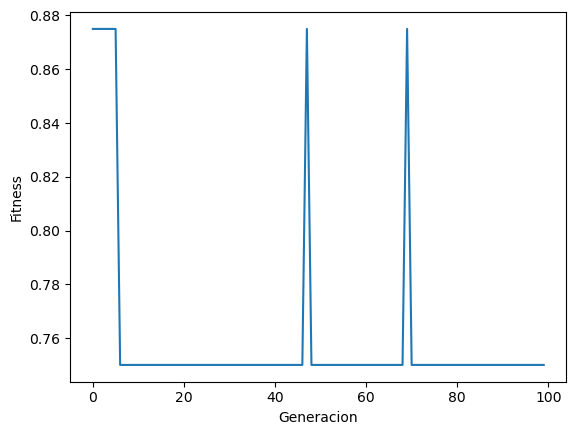

In [19]:
#Graficas fitness por generacion con matplotlib
import matplotlib.pyplot as plt
plt.plot(fitness)
plt.xlabel('Generacion')
plt.ylabel('Fitness')
plt.show()

In [15]:
imprimir_arbol(poblacion[np.argmax(fitness)])
accuracy = evaluar_arbol_completo(poblacion[np.argmax(fitness)])

OR
--C
--AND
----OR
------OR
--------A
--------B
------AND
--------NOT
----------A
--------OR
----------C
----------A
----NOT
------OR
--------NOT
----------AND
------------NOT
--------------OR
----------------AND
------------------C
------------------A
----------------AND
------------------NOT
--------------------OR
----------------------OR
------------------------NOT
--------------------------OR
----------------------------A
----------------------------B
------------------------OR
--------------------------NOT
----------------------------B
--------------------------OR
----------------------------B
----------------------------C
----------------------OR
------------------------OR
--------------------------NOT
----------------------------C
--------------------------AND
----------------------------B
----------------------------B
------------------------A
------------------C
------------AND
--------------OR
----------------A
----------------OR
------------------AND
--------------------NOT

In [10]:
accuracy

0.625